In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

import env
import acquire
import split_scale
#import features
import prep
#import exploration
#import feature_selection
#import model

### Acquisition and initial data exploration

In [3]:
df = acquire.prep_telco()

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
senior_citizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
internet_service_type_id,7043.0,1.872923,0.737796,1.00,1.0,2.00,2.00,3.00
contract_type_id,7043.0,1.690473,0.833755,1.00,1.0,1.00,2.00,3.00
payment_type_id,7043.0,2.315633,1.148907,1.00,1.0,2.00,3.00,4.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [7]:
df.head(2)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,No,...,No,Yes,Yes,No,2,Yes,2,65.6,593.3,No
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,...,No,No,No,Yes,1,No,2,59.9,542.4,No


In [8]:
df.dtypes

customer_id                  object
gender                       object
senior_citizen                int64
partner                      object
dependents                   object
tenure                        int64
phone_service                object
multiple_lines               object
internet_service_type_id      int64
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
contract_type_id              int64
paperless_billing            object
payment_type_id               int64
monthly_charges             float64
total_charges                object
churn                        object
dtype: object

### Initial data prep

In [9]:
df.total_charges = df.total_charges.replace(r'^\s*$', np.nan, regex=True)
df = df[df.total_charges.isna() == False]
df['total_charges'] = df['total_charges'].astype(float)
df['churn'] = df.churn == 'Yes'
df['senior_citizen'] = df.senior_citizen == 1
df['is_male'] = df.gender == 'Male'
df['paperless_billing'] = df.paperless_billing == 'Yes'

df['family'] = (df.partner == 'Yes') | (df.dependents == 'Yes')

df['phone'] = (df.phone_service == 'Yes') | (df.multiple_lines == 'Yes')
df['streaming'] = (df.streaming_tv == 'Yes') | (df.streaming_movies == 'Yes')
df['tech_protection'] = (df.device_protection == 'Yes') | (df.tech_support == 'Yes') | (df.online_backup == 'Yes') | (df.online_security == 'Yes')

In [10]:
df.head(2)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,is_male,family,phone,streaming,tech_protection
0,0002-ORFBO,Female,False,Yes,Yes,9,Yes,No,1,No,...,True,2,65.6,593.3,False,False,True,True,True,True
1,0003-MKNFE,Male,False,No,No,9,Yes,Yes,1,No,...,False,2,59.9,542.4,False,True,False,True,True,False


In [11]:
df = prep.clean_telco(df)

### Initial Questions and exploration



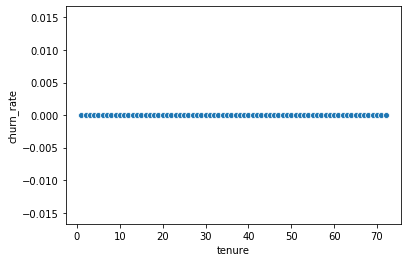

In [12]:
#tenure by churn rate
df_churned = df[['tenure','churn']].groupby('tenure').sum()
df_total = df[['tenure','churn']].groupby('tenure').count()
df_churn_rate = pd.merge(df_churned,df_total,how='inner',on='tenure')
df_churn_rate['churn_rate'] = df_churn_rate.churn_x / df_churn_rate.churn_y
df_churn_rate = df_churn_rate.reset_index()
all_contracts = sns.scatterplot(x='tenure',y='churn_rate',data=df_churn_rate)
plt.show()


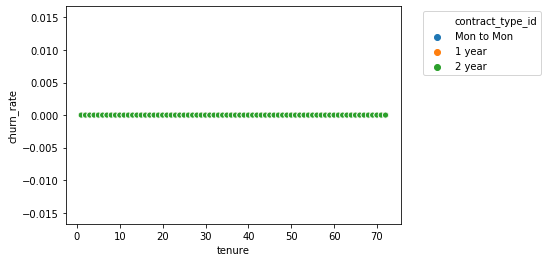

In [13]:
#tenure by churn rate and contract type
# Month to month churn at high rate. M2M does get closer to the average after about 3 years of tenure.
df_churned = df[['tenure','contract_type_id','churn']].groupby(['tenure','contract_type_id']).sum()
df_total = df[['tenure','contract_type_id','churn']].groupby(['tenure','contract_type_id']).count()

df_churn_rate = pd.merge(df_churned,df_total,how='inner',on=['tenure','contract_type_id'])

df_churn_rate['churn_rate'] = df_churn_rate.churn_x / df_churn_rate.churn_y
df_churn_rate = df_churn_rate.reset_index()


df_churn_rate
df_churn_rate['contract_type_id'] = np.where(df_churn_rate['contract_type_id']== 1,'Mon to Mon',(np.where(df_churn_rate['contract_type_id']== 2,'1 year',(np.where(df_churn_rate['contract_type_id']==3,'2 year',"")))))
all_contracts = sns.scatterplot(x='tenure',y='churn_rate',data=df_churn_rate,hue='contract_type_id',palette='tab10')
plt.legend(bbox_to_anchor=(1.05,1),loc=2)

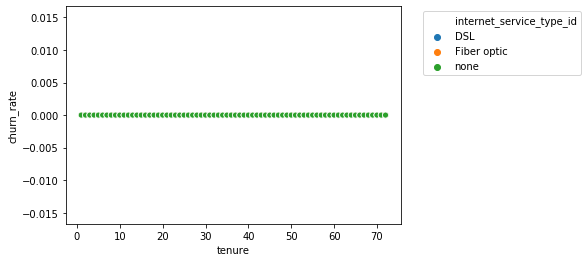

In [15]:
#tenure by churn rate and internet type
# Month to month churn at high rate. M2M does get closer to the average after about 3 years of tenure.
df_churned = df[['tenure','internet_service_type_id','churn']].groupby(['tenure','internet_service_type_id']).sum()
df_total = df[['tenure','internet_service_type_id','churn']].groupby(['tenure','internet_service_type_id']).count()

df_churn_rate = pd.merge(df_churned,df_total,how='inner',on=['tenure','internet_service_type_id'])

df_churn_rate['churn_rate'] = df_churn_rate.churn_x / df_churn_rate.churn_y
df_churn_rate = df_churn_rate.reset_index()


df_churn_rate
df_churn_rate['internet_service_type_id'] = np.where(df_churn_rate['internet_service_type_id']== 1,'DSL',(np.where(df_churn_rate['internet_service_type_id']== 2,'Fiber optic',(np.where(df_churn_rate['internet_service_type_id']==3,'none',"")))))
all_contracts = sns.scatterplot(x='tenure',y='churn_rate',data=df_churn_rate,hue='internet_service_type_id',palette='tab10')
plt.legend(bbox_to_anchor=(1.05,1),loc=2)

In [16]:
# churn by internet type. Fiber Optic customers churning at higher rate than DSL and no internet
df_churned = df[['internet_service_type_id','churn']].groupby('internet_service_type_id').sum()
df_total = df[['internet_service_type_id','churn']].groupby('internet_service_type_id').count()
df_churn_rate = pd.merge(df_churned,df_total,how='inner',on='internet_service_type_id')
df_churn_rate['churn_rate'] = df_churn_rate.churn_x / df_churn_rate.churn_y
df_churn_rate = df_churn_rate.reset_index()
df_churn_rate[['internet_service_type_id','churn_rate']]

,internet_service_type_id,churn_rate
0,1,0.0
1,2,0.0
2,3,0.0


In [17]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,monthly_charges,total_charges,churn,is_male,family,phone,streaming,tech_protection,internet_security,services
0,0002-ORFBO,Female,False,Yes,Yes,9,Yes,No,1,No,...,65.6,593.30,False,False,True,True,True,True,True,internet w phone
1,0003-MKNFE,Male,False,No,No,9,Yes,Yes,1,No,...,59.9,542.40,False,True,False,True,True,False,False,internet w phone
2,0004-TLHLJ,Male,False,No,No,4,Yes,No,2,No,...,73.9,280.85,False,True,False,True,False,True,False,internet w phone
3,0011-IGKFF,Male,True,Yes,No,13,Yes,No,2,No,...,98.0,1237.85,False,True,True,True,True,True,True,internet w phone
4,0013-EXCHZ,Female,True,Yes,No,3,Yes,No,2,No,...,83.9,267.40,False,False,True,True,True,True,False,internet w phone


In [18]:
# churn by phone service. No difference in churn rate
df_churned = df[['phone','churn']].groupby('phone').sum()
df_total = df[['phone','churn']].groupby('phone').count()
df_churn_rate = pd.merge(df_churned,df_total,how='inner',on='phone')
df_churn_rate['churn_rate'] = df_churn_rate.churn_x / df_churn_rate.churn_y
df_churn_rate = df_churn_rate.reset_index()
df_churn_rate[['phone','churn_rate']]

,phone,churn_rate
0,False,0.0
1,True,0.0


In [19]:
# churn by phone service. No difference in churn rate
df_churned = df[['phone','churn']].groupby('phone').sum()
df_total = df[['phone','churn']].groupby('phone').count()
df_churn_rate = pd.merge(df_churned,df_total,how='inner',on='phone')
df_churn_rate['churn_rate'] = df_churn_rate.churn_x / df_churn_rate.churn_y
df_churn_rate = df_churn_rate.reset_index()
df_churn_rate[['phone','churn_rate']]

,phone,churn_rate
0,False,0.0
1,True,0.0


In [20]:
# churn by online security. Churn rate is considerably higher for those with no online security
df_churned = df[['online_security','churn']].groupby('online_security').sum()
df_total = df[['online_security','churn']].groupby('online_security').count()
df_churn_rate = pd.merge(df_churned,df_total,how='inner',on='online_security')
df_churn_rate['churn_rate'] = df_churn_rate.churn_x / df_churn_rate.churn_y
df_churn_rate = df_churn_rate.reset_index()
df_churn_rate[['online_security','churn_rate']]

,online_security,churn_rate
0,No,0.0
1,No internet service,0.0
2,Yes,0.0


In [21]:
# churn by online backup. Churn rate is considerably higher for those with no online security or backup
df_churned = df[['online_backup','churn']].groupby('online_backup').sum()
df_total = df[['online_backup','churn']].groupby('online_backup').count()
df_churn_rate = pd.merge(df_churned,df_total,how='inner',on='online_backup')
df_churn_rate['churn_rate'] = df_churn_rate.churn_x / df_churn_rate.churn_y
df_churn_rate = df_churn_rate.reset_index()
df_churn_rate[['online_backup','churn_rate']]

,online_backup,churn_rate
0,No,0.0
1,No internet service,0.0
2,Yes,0.0


In [22]:
# churn by senior citizen. Senior citizen churn rate is slightly higher than non senior citizen.
df_churned = df[['senior_citizen','churn']].groupby('senior_citizen').sum()
df_total = df[['senior_citizen','churn']].groupby('senior_citizen').count()
df_churn_rate = pd.merge(df_churned,df_total,how='inner',on='senior_citizen')
df_churn_rate['churn_rate'] = df_churn_rate.churn_x / df_churn_rate.churn_y
df_churn_rate = df_churn_rate.reset_index()
df_churn_rate[['senior_citizen','churn_rate']]

,senior_citizen,churn_rate
0,False,0.0
1,True,0.0


In [23]:
#Churn rate of all customers vs monthly charges in top and bottom 25%
# Price does not look to be a driving factor in churn.
df_churned = df[['monthly_charges','churn']]
df_churned['quant_25'] = df.monthly_charges < df_churned['monthly_charges'].quantile(.25)
df_churned['quant_75'] = df.monthly_charges > df_churned['monthly_charges'].quantile(.75)
print("Customers churned at an average rate of: " ,round(df_churned.churn.sum()/len(df_churned),3))
print("Customers in the top 25% of monthly charges churned at a rate of: ",df_churned.quant_75.sum()/len(df_churned))
print("Customers in the bottom 25% of monthly charges churned at a rate of: ", df_churned.quant_25.sum()/len(df_churned))

Customers churned at an average rate of:  0.0
Customers in the top 25% of monthly charges churned at a rate of:  0.25
Customers in the bottom 25% of monthly charges churned at a rate of:  0.25


### Data prep

- Converting churn and senior citizen to boolean.
- Combining partner and dependents into one variable called 'family' if either column is Yes.
- Combining phone_service and multiple_lines into one variable called phone if either column is Yes.



In [24]:
#converting to bool, dropping redundant columns

df.drop(['device_protection','tech_support','online_backup','online_security','streaming_tv','streaming_movies','gender','partner','dependents','customer_id','phone_service','multiple_lines'],axis=1,inplace=True)

In [25]:
len(df)

7032

#### Split and Scale

In [26]:
train, test = split_scale.split_my_data(df,train_ratio=.8,seed=123,stratify=None)

#### Create X and y train/test

In [27]:
X_train = train.drop(['churn'],axis=1)
y_train = train.churn
X_test = test.drop(['churn'],axis=1)
y_test = test.churn

#### Fit model to training data

In [33]:
clf = DecisionTreeClassifier(criterion='entropy',max_depth=4,random_state=123)

In [34]:
clf.fit(X_train,y_train)

ValueError: could not convert string to float: 'internet w phone'

In [30]:
y_pred = clf.predict(X_train)

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [31]:
y_pred_prob = clf.predict_proba(X_train)
y_pred_prob

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [32]:
clf.score(X_train,y_train)

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [ ]:
confusion_matrix(y_train,y_pred)

In [ ]:
clf.score(X_test,y_test)

In [ ]:
print(classification_report(y_train,y_pred))

In [ ]:
import graphviz
from graphviz import Graph

dot_data = export_graphviz(clf,out_file=None)
graph = graphviz.Source(dot_data)

graph.render('telco_churn',view=True)

In [ ]:
feature_importance = clf.feature_importances_.round(5)
feature_importance

In [ ]:
list_X = list(X_train.columns)
list_X

In [ ]:
tree_scores = dict(zip(list_X,clf.feature_importances_.round(4)))

In [ ]:
sorted(tree_scores.items(),key=lambda kv: kv[1],reverse=True)

In [ ]:
sns.swarmplot(x="contract_type_id", y="total_charges", data=train, hue="churn", palette="Set2")
ax = sns.boxplot(x="contract_type_id", y="total_charges", data=train,
        showcaps=True,boxprops={'facecolor':'None'},
        showfliers=True,whiskerprops={'linewidth':0})
plt.legend(loc=1)